In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

# For nicer printing
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")

In [2]:
 data_path = pd.read_csv("UPHC.csv")

In [3]:
 data_path.head()

,Years,Uphc,Mean_Air_Temperature,Annual_sunshine,Maximum_Temperature,Annual_Precipitation,minimum_air_temperature
0,01/04/2025,449.060,10.300,246.300,16.200,19.800,4.400
1,01/04/2024,446.160,9.200,124.200,13.100,79.900,5.200
2,01/04/2023,442.700,8.300,153.000,12.600,64.100,4.000
3,01/04/2022,419.030,8.800,177.800,13.800,23.900,3.800
4,01/04/2021,390.970,6.100,220.300,11.600,13.500,0.600


In [4]:
data_path["Years"] = pd.to_datetime(data_path["Years"], dayfirst=True)

In [5]:
df= data_path

In [6]:
df = df.rename(columns={"Years": "Date"})

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     89 non-null     datetime64[ns]
 1   Uphc                     89 non-null     float64       
 2   Mean_Air_Temperature     89 non-null     float64       
 3   Annual_sunshine          89 non-null     float64       
 4   Maximum_Temperature      89 non-null     float64       
 5   Annual_Precipitation     89 non-null     float64       
 6   minimum_air_temperature  89 non-null     float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 5.7 KB


In [8]:
df = df.sort_values("Date").set_index("Date")

In [9]:
df.head()

,Uphc,Mean_Air_Temperature,Annual_sunshine,Maximum_Temperature,Annual_Precipitation,minimum_air_temperature
Date,,,,,,
2018-04-01,411.310,9.400,114.100,13.100,79.100,5.700
2018-05-01,427.620,17.000,231.100,22.300,37.500,11.800
2018-06-01,430.210,16.100,179.400,20.900,72.100,11.200
2018-07-01,440.820,16.100,161.900,20.400,60.000,11.700
2018-08-01,421.570,16.600,167.000,21.400,55.500,11.900


In [10]:
df=df.dropna()

In [11]:
df.head()

,Uphc,Mean_Air_Temperature,Annual_sunshine,Maximum_Temperature,Annual_Precipitation,minimum_air_temperature
Date,,,,,,
2018-04-01,411.310,9.400,114.100,13.100,79.100,5.700
2018-05-01,427.620,17.000,231.100,22.300,37.500,11.800
2018-06-01,430.210,16.100,179.400,20.900,72.100,11.200
2018-07-01,440.820,16.100,161.900,20.400,60.000,11.700
2018-08-01,421.570,16.600,167.000,21.400,55.500,11.900


In [12]:
df.index = pd.to_datetime(df.index)
df = df.asfreq('MS')


In [13]:
print("Missing values per column:")
print(df.isna().sum())

Missing values per column:
Uphc                       0
Mean_Air_Temperature       0
Annual_sunshine            0
Maximum_Temperature        0
Annual_Precipitation       0
minimum_air_temperature    0
dtype: int64


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 89 entries, 2018-04-01 to 2025-08-01
Freq: MS
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Uphc                     89 non-null     float64
 1   Mean_Air_Temperature     89 non-null     float64
 2   Annual_sunshine          89 non-null     float64
 3   Maximum_Temperature      89 non-null     float64
 4   Annual_Precipitation     89 non-null     float64
 5   minimum_air_temperature  89 non-null     float64
dtypes: float64(6)
memory usage: 4.9 KB


In [15]:
# Target series
y = df["Uphc"]

# Exogenous regressors (weather)
X = df[[
    "Mean_Air_Temperature",
    "Annual_sunshine",
    "Maximum_Temperature",
    "Annual_Precipitation",
    "minimum_air_temperature"
]]

In [16]:
test_horizon = 12   # you can change this

train_y = y.iloc[:-test_horizon]
test_y  = y.iloc[-test_horizon:]

train_X = X.iloc[:-test_horizon]
test_X  = X.iloc[-test_horizon:]

print(train_y.index[[0, -1]])
print(test_y.index[[0, -1]])



DatetimeIndex(['2018-04-01', '2024-08-01'], dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2024-09-01', '2025-08-01'], dtype='datetime64[ns]', name='Date', freq=None)


In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [18]:
sarimax_model = SARIMAX(
    train_y,
    exog=train_X,
    order=(1, 1, 1),          # (p,d,q)
    seasonal_order=(1, 1, 1, 12),  # (P,D,Q,s) with yearly seasonality (12 months)
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

print(sarimax_model.summary())

C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                               Uphc   No. Observations:                   77
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -224.030
Date:                            Tue, 25 Nov 2025   AIC                            468.060
Time:                                    14:54:10   BIC                            487.180
Sample:                                04-01-2018   HQIC                           475.341
                                     - 08-01-2024                                         
Covariance Type:                              opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Mean_Air_Temperature        9.8122    125.904      0.078      0.938    -236.955     256.

In [19]:
import joblib

# Save the fitted SARIMAX model
joblib.dump(sarimax_model, 'uPHC_sarimax_forecast_model.pkl')

print("Model saved successfully!")


Model saved successfully!


In [20]:
# Forecast same length as test set
sarimax_forecast = sarimax_model.forecast(
    steps=test_horizon,
    exog=test_X
)

# Make sure it’s a Series with the correct index
sarimax_forecast = pd.Series(sarimax_forecast, index=test_y.index)


In [21]:
mae  = np.mean(np.abs(test_y - sarimax_forecast))
rmse = np.sqrt(np.mean((test_y - sarimax_forecast) ** 2))

def mape(actual, pred):
    return np.mean(np.abs((actual - pred) / actual)) * 100

mape_val = mape(test_y, sarimax_forecast)

print("\n=== SARIMAX Test Forecast Accuracy ===")
print(f"MAE  : {mae:,.3f}")
print(f"RMSE : {rmse:,.3f}")
print(f"MAPE : {mape_val:,.2f}%")

# Optional: table of actual vs forecast
comparison = pd.concat([test_y, sarimax_forecast], axis=1)
comparison.columns = ["Actual", "SARIMAX_Forecast"]
print("\nActual vs Forecast:")
print(comparison)



=== SARIMAX Test Forecast Accuracy ===
MAE  : 10.078
RMSE : 14.574
MAPE : 2.19%

Actual vs Forecast:
            Actual  SARIMAX_Forecast
Date                                
2024-09-01 434.510           433.537
2024-10-01 433.170           432.834
2024-11-01 438.130           415.721
2024-12-01 429.680           434.985
2025-01-01 440.700           441.138
2025-02-01 462.440           449.439
2025-03-01 478.870           442.543
2025-04-01 449.060           460.272
2025-05-01 461.700           456.260
2025-06-01 469.210           476.318
2025-07-01 460.500           478.458
2025-08-01 455.210           454.779


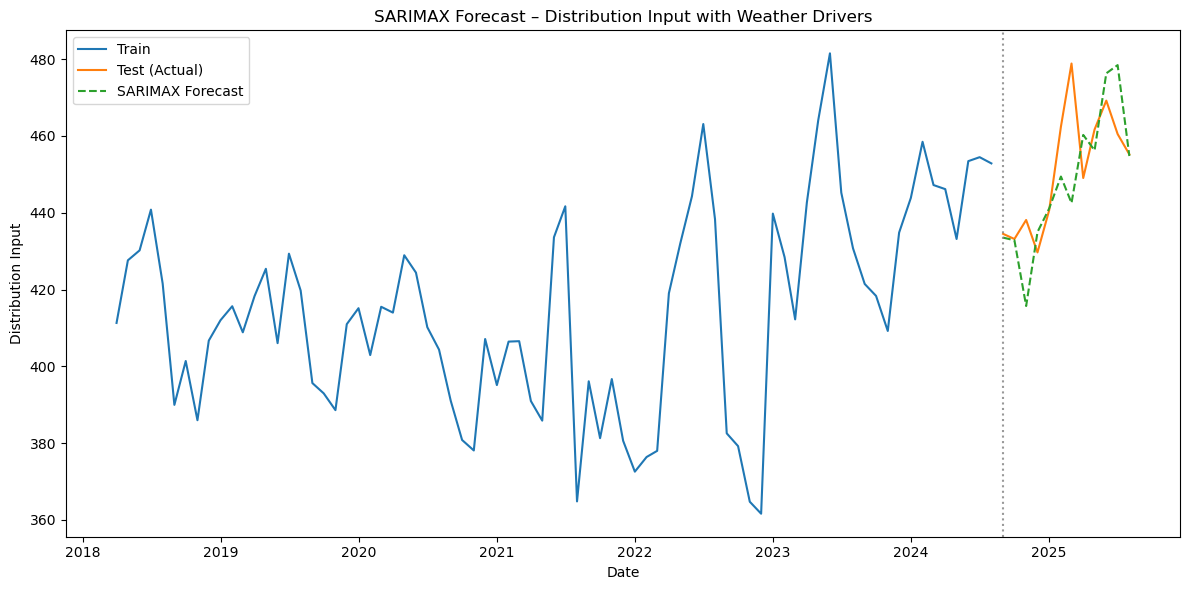

In [22]:
plt.figure(figsize=(12, 6))

# Train and test
plt.plot(train_y.index, train_y, label="Train")
plt.plot(test_y.index, test_y, label="Test (Actual)")

# SARIMAX forecast
plt.plot(sarimax_forecast.index, sarimax_forecast,
         label="SARIMAX Forecast", linestyle="--")

# Mark train/test split
plt.axvline(test_y.index[0], color="grey", linestyle=":", alpha=0.8)

plt.title("SARIMAX Forecast – Distribution Input with Weather Drivers")
plt.xlabel("Date")
plt.ylabel("Distribution Input")
plt.legend()
plt.tight_layout()
plt.show()

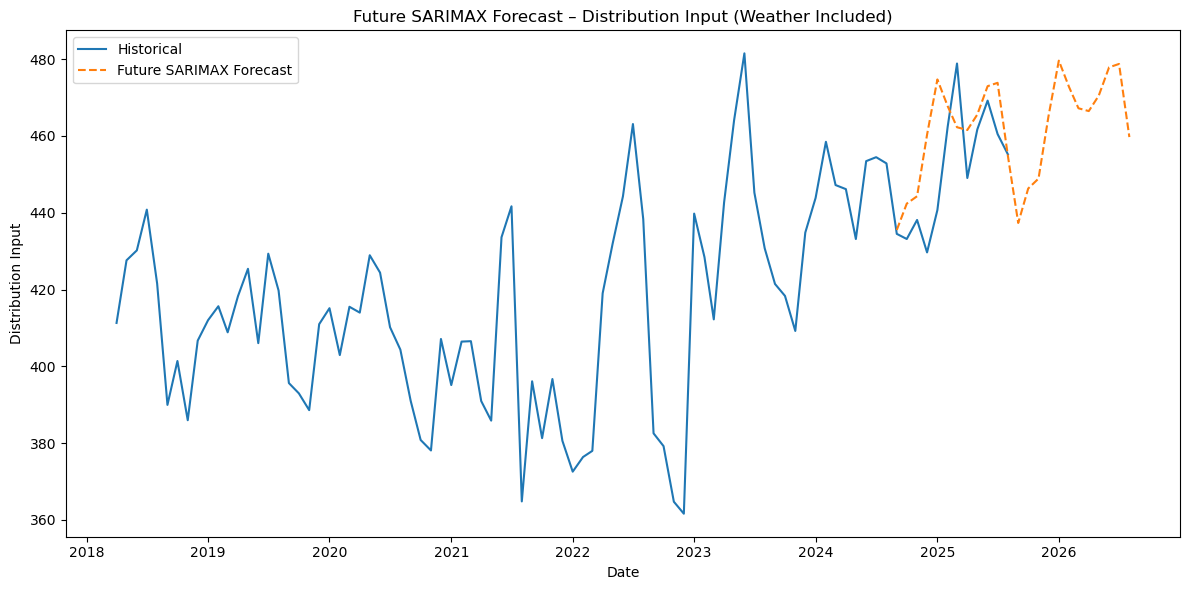

In [23]:
future_steps = 24

# Get the last row and repeat it for 24 months
future_X = pd.DataFrame(
    [X.iloc[-1].values] * future_steps,
    columns=X.columns,
    index=pd.date_range(start=X.index[-1] + pd.offsets.MonthBegin(),
                        periods=future_steps, freq='MS')
)

future_forecast = sarimax_model.forecast(
    steps=future_steps,
    exog=future_X
)

plt.figure(figsize=(12,6))
plt.plot(y.index, y, label="Historical")
plt.plot(future_forecast.index, future_forecast, label="Future SARIMAX Forecast", linestyle="--")

plt.title("Future SARIMAX Forecast – Distribution Input (Weather Included)")
plt.xlabel("Date")
plt.ylabel("Distribution Input")
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
# Create a DataFrame for the 4 future months
future_weather = pd.DataFrame({
    "Date": [
        "2025-09-01",
        "2025-10-01",
        "2025-11-01",
        "2025-12-01"
    ],
    "Mean_Air_Temperature": [13.6, 11.0, 6.8, 6.6],
    "Annual_sunshine":      [111.0, 97.5, 57.5, 28.2],
    "Maximum_Temperature":  [17.3, 14.5, 9.8, 9.1],
    "Annual_Precipitation": [159.6, 81.9, 75.8, 86.3],
    "minimum_air_temperature": [9.8, 7.4, 3.9, 4.1]
})

# Set Date as index and ensure monthly-start frequency
future_X = future_weather.set_index("Date")
future_X.index = pd.to_datetime(future_X.index)
future_X = future_X.asfreq("MS")

print(future_X)

            Mean_Air_Temperature  Annual_sunshine  Maximum_Temperature  \
Date                                                                     
2025-09-01                13.600          111.000               17.300   
2025-10-01                11.000           97.500               14.500   
2025-11-01                 6.800           57.500                9.800   
2025-12-01                 6.600           28.200                9.100   

            Annual_Precipitation  minimum_air_temperature  
Date                                                       
2025-09-01               159.600                    9.800  
2025-10-01                81.900                    7.400  
2025-11-01                75.800                    3.900  
2025-12-01                86.300                    4.100  


In [25]:
df.index = pd.to_datetime(df.index)
df = df.asfreq("MS")


In [26]:
print(df.index.max())


2025-08-01 00:00:00


In [27]:
start_date = "2025-10-01"   # or df.index.max() + pd.offsets.MonthBegin(1)

# 1. Get forecast object for the future period
forecast_res = sarimax_model.get_forecast(
    steps=len(future_X),
    exog=future_X
)

# 2. Extract mean forecast and 95% CI
future_pred = forecast_res.predicted_mean              # Series
future_ci   = forecast_res.conf_int(alpha=0.05)        # DataFrame with lower/upper

# 3. Make sure indices line up with your future_X dates
future_pred.index = future_X.index
future_ci.index   = future_X.index
future_ci.columns = ["Lower_95", "Upper_95"]

# 4. Combine everything
future_results = pd.concat([future_pred, future_ci], axis=1)
future_results.columns = ["Forecast", "Lower_95", "Upper_95"]

print(future_results)


            Forecast  Lower_95  Upper_95
Date                                    
2025-09-01   428.158   387.788   468.528
2025-10-01   424.663   379.622   469.703
2025-11-01   416.239   369.252   463.225
2025-12-01   429.222   380.907   477.536
